# A.4 : classification problem, Graph Convolutional Network, impact of SBS / INDEL mutational signatures
In this notebook, we compare, for the classification problem with the Graph Convolutional Network, the following configurations :
- with only SBS mutational signatures
- with only INDEL mutational signatures
- with combination of both

## Table of contents

1. [Only SBS mutational signatures](#1-sbs)
2. [Only INDEL mutational signatures](#2-indel)
3. [SBS + INDEL mutational signatures](#3-comb)
4. [Evaluate performances](#4-performances)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import shap
import torch

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.GNNClassifierTrainTestManager import GNNClassifierTrainTestManager

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import from_networkx

from utils.FeatureSelector import FeatureSelector
from utils.PreProcessor import PreProcessor

#### Set hyper-parameters

In [19]:
n_features = 6
n_epochs = 100
lr = 0.005
reg = 0.005
max_neighbors = 2
architecture = 'gcn'

#### Reading and PreProcessor

In [20]:
# Reading dataset
df = pd.read_excel('data/cohort-dataset.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = PreProcessor.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = PreProcessor.relabel_patients(df, "Progression_1", "Time to progression (days)", t)

# Select group
group = df["Tumour type"].to_numpy()

# Extract labels
y = df["Progression_1"].to_numpy()

### 1. Only SBS mutational signatures

#### Feature selection

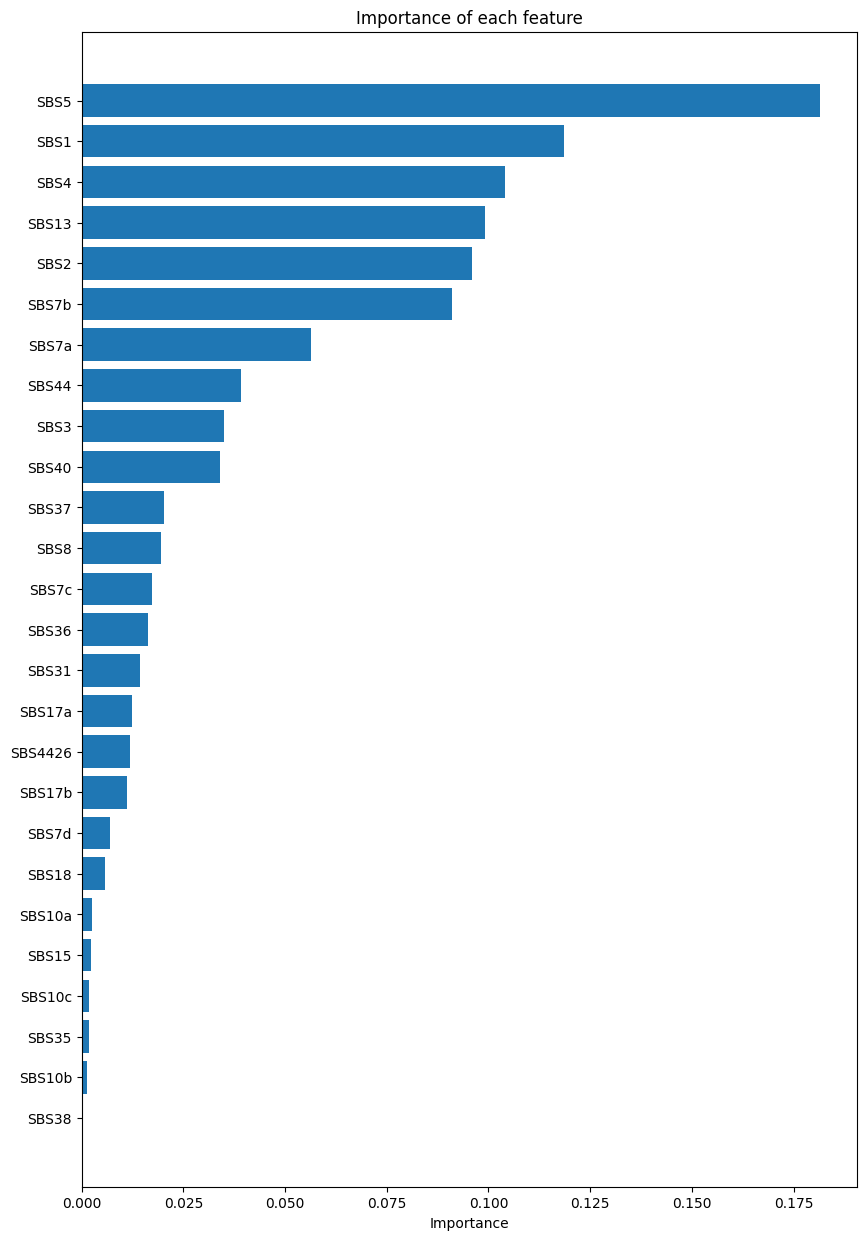

In [21]:
features_name_sbs = ["SBS1",
                     "SBS2",
                     "SBS3",
                     "SBS4",
                     "SBS5",
                     "SBS7a",
                     "SBS7b",
                     "SBS7c",
                     "SBS7d",
                     "SBS8",
                     "SBS10a",
                     "SBS10b",
                     "SBS10c",
                     "SBS13",
                     "SBS15",
                     "SBS17a",
                     "SBS17b",
                     "SBS18",
                     "SBS31",
                     "SBS35",
                     "SBS36",
                     "SBS37",
                     "SBS38",
                     "SBS40",
                     "SBS44",
                     "SBS4426"]

# Compute feature importance
features_name_sbs = FeatureSelector.feature_importance(df.loc[:, features_name_sbs], y, True)

# Select the most n_features important features
if n_features < len(features_name_sbs):
    features_name_sbs = features_name_sbs[:n_features]

# Extract features
X_sbs = df.loc[:, features_name_sbs].to_numpy()

#### Execute the leave one out CV

In [22]:
manager_sbs = GNNClassifierTrainTestManager(architecture)
scores_sbs, classes_sbs, train_loss_sbs, val_loss_sbs, nx_graph_sbs = manager_sbs.leave_one_out_cv(X_sbs, y, group, n_epochs, lr, reg, max_neighbors)

### 2. Only INDEL mutational signatures

#### Feature selection

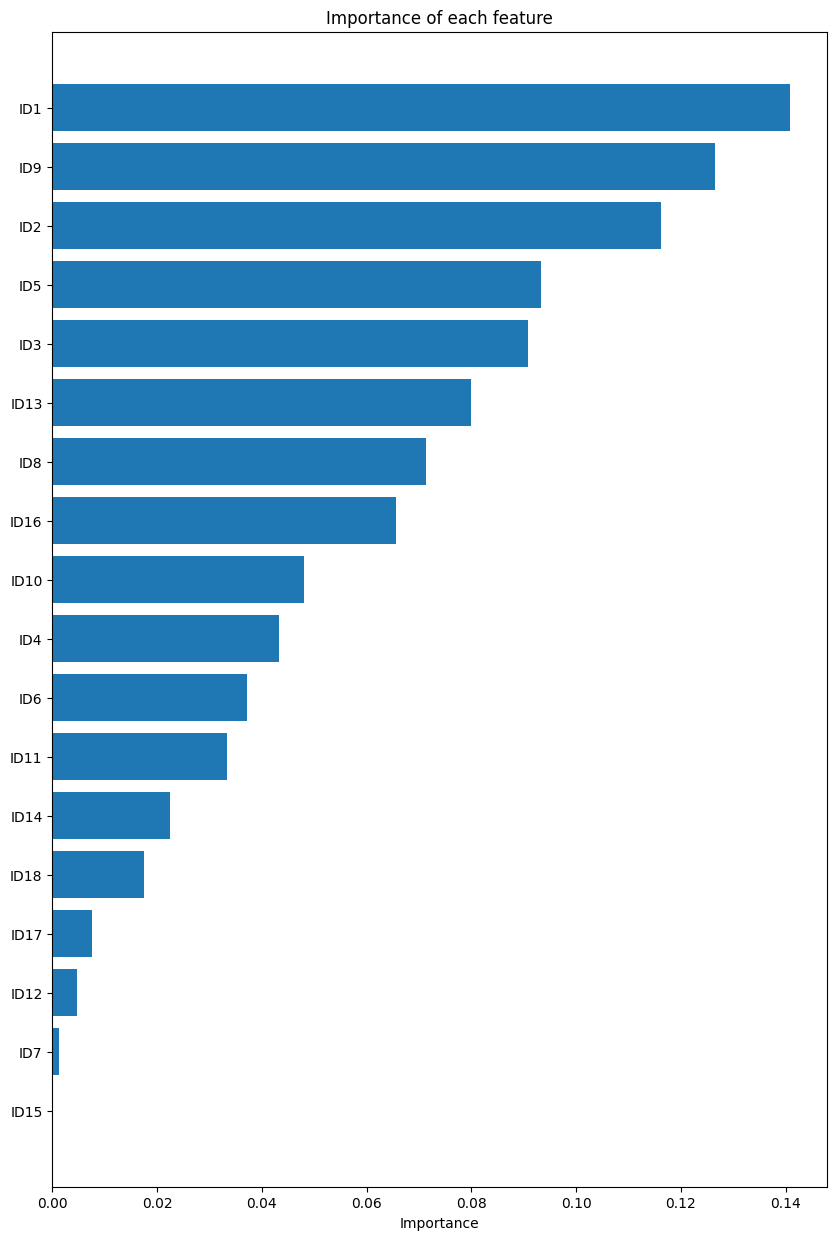

In [23]:
features_name_indel = ["ID1",
                       "ID2",
                       "ID3",
                       "ID4",
                       "ID5",
                       "ID6",
                       "ID7",
                       "ID8",
                       "ID9",
                       "ID10",
                       "ID11",
                       "ID12",
                       "ID13",
                       "ID14",
                       "ID15",
                       "ID16",
                       "ID17",
                       "ID18"]

# Compute feature importance
features_name_indel = FeatureSelector.feature_importance(df.loc[:, features_name_indel], y, True)

# Select the most n_features important features
if n_features < len(features_name_indel):
    features_name_indel = features_name_indel[:n_features]

# Extract features
X_indel = df.loc[:, features_name_indel].to_numpy()

#### Execute the leave one out CV

In [24]:
manager_indel = GNNClassifierTrainTestManager(architecture)
scores_indel, classes_indel, train_loss_indel, val_loss_indel, nx_graph_indel = manager_indel.leave_one_out_cv(X_indel, y, group, n_epochs, lr, reg, max_neighbors)

### 3. SBS + INDEL mutational signatures

#### Feature selection

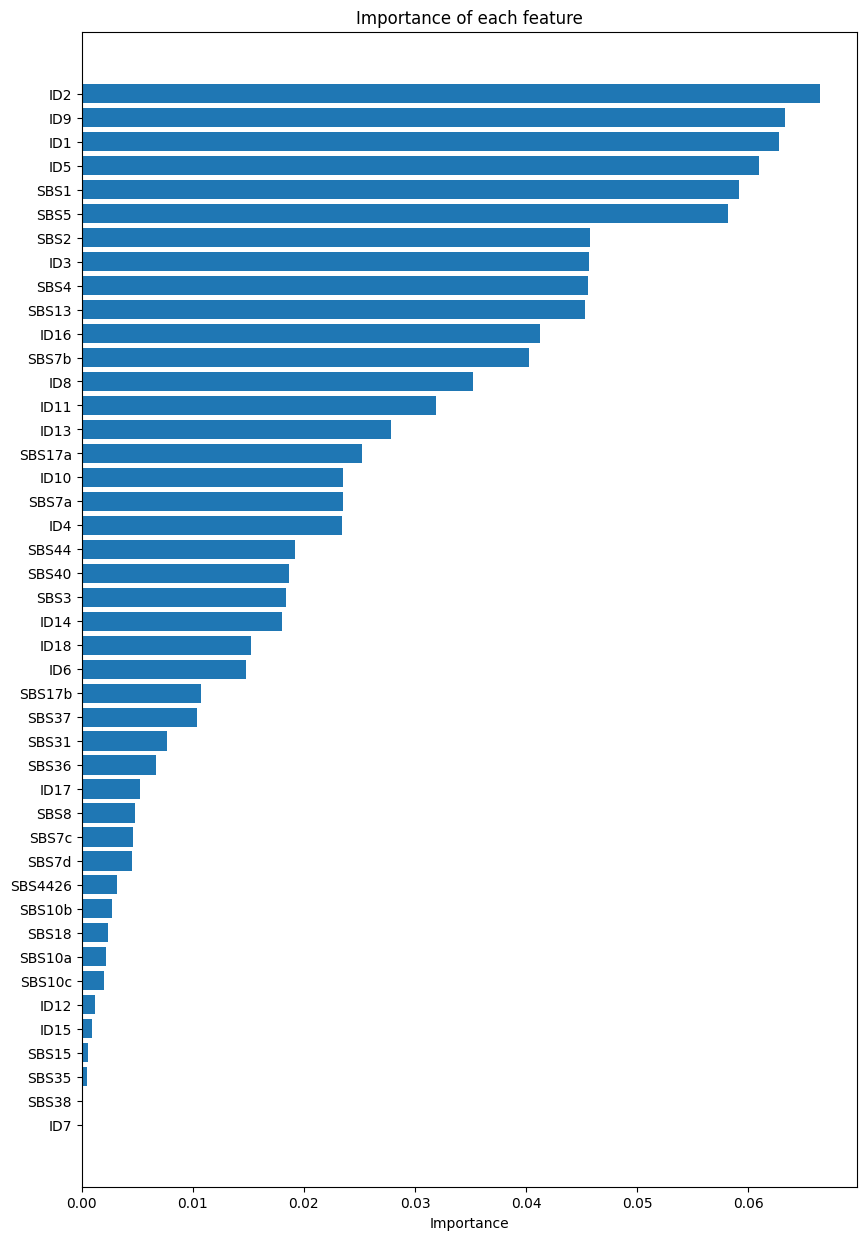

In [25]:
features_name_comb = ["SBS1",
                      "SBS2",
                      "SBS3",
                      "SBS4",
                      "SBS5",
                      "SBS7a",
                      "SBS7b",
                      "SBS7c",
                      "SBS7d",
                      "SBS8",
                      "SBS10a",
                      "SBS10b",
                      "SBS10c",
                      "SBS13",
                      "SBS15",
                      "SBS17a",
                      "SBS17b",
                      "SBS18",
                      "SBS31",
                      "SBS35",
                      "SBS36",
                      "SBS37",
                      "SBS38",
                      "SBS40",
                      "SBS44",
                      "SBS4426",
                      "ID1",
                      "ID2",
                      "ID3",
                      "ID4",
                      "ID5",
                      "ID6",
                      "ID7",
                      "ID8",
                      "ID9",
                      "ID10",
                      "ID11",
                      "ID12",
                      "ID13",
                      "ID14",
                      "ID15",
                      "ID16",
                      "ID17",
                      "ID18"]

# Compute feature importance
features_name_comb = FeatureSelector.feature_importance(df.loc[:, features_name_comb], y, True)

# Select the most n_features important features
if n_features < len(features_name_comb):
    features_name_comb = features_name_comb[:n_features]

# Extract features
X_comb = df.loc[:, features_name_comb].to_numpy()

#### Execute the leave one out CV

In [26]:
manager_comb = GNNClassifierTrainTestManager(architecture)
scores_comb, classes_comb, train_loss_comb, val_loss_comb, nx_graph_comb = manager_comb.leave_one_out_cv(X_comb, y, group, n_epochs, lr, reg, max_neighbors)

### 4. Evaluate performances

#### Classification metrics

In [27]:
# No mutational signatures
fpr_sbs, tpr_sbs = ClassificationMetrics.compute_roc_curve(y, scores_sbs)
sensitivity_sbs, specificity_sbs = ClassificationMetrics.compute_sensitivity_specificity(y,classes_sbs)
auc_sbs = ClassificationMetrics.compute_auc(y,scores_sbs)

# Only mutational signatures
fpr_indel, tpr_indel = ClassificationMetrics.compute_roc_curve(y, scores_indel)
sensitivity_indel, specificity_indel = ClassificationMetrics.compute_sensitivity_specificity(y,classes_indel)
auc_indel = ClassificationMetrics.compute_auc(y,scores_indel)

# Initial biomarkers + mutational signatures
fpr_comb, tpr_comb = ClassificationMetrics.compute_roc_curve(y, scores_comb)
sensitivity_comb, specificity_comb = ClassificationMetrics.compute_sensitivity_specificity(y,classes_comb)
auc_comb = ClassificationMetrics.compute_auc(y,scores_comb)

#### SHAP values

In [28]:
# No sigmut
pyg_graph_sbs = from_networkx(nx_graph_sbs)
explainer_sbs = Explainer(
    model=manager_sbs.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_sbs = explainer_sbs(pyg_graph_sbs.x, pyg_graph_sbs.edge_index)

# Only sigmut
pyg_graph_indel = from_networkx(nx_graph_indel)
explainer_indel = Explainer(
    model=manager_indel.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_indel = explainer_indel(pyg_graph_indel.x, pyg_graph_indel.edge_index)

# sigmut + others
pyg_graph_comb = from_networkx(nx_graph_comb)
explainer_comb = Explainer(
    model=manager_comb.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_comb = explainer_comb(pyg_graph_comb.x, pyg_graph_comb.edge_index)


#### Plot results

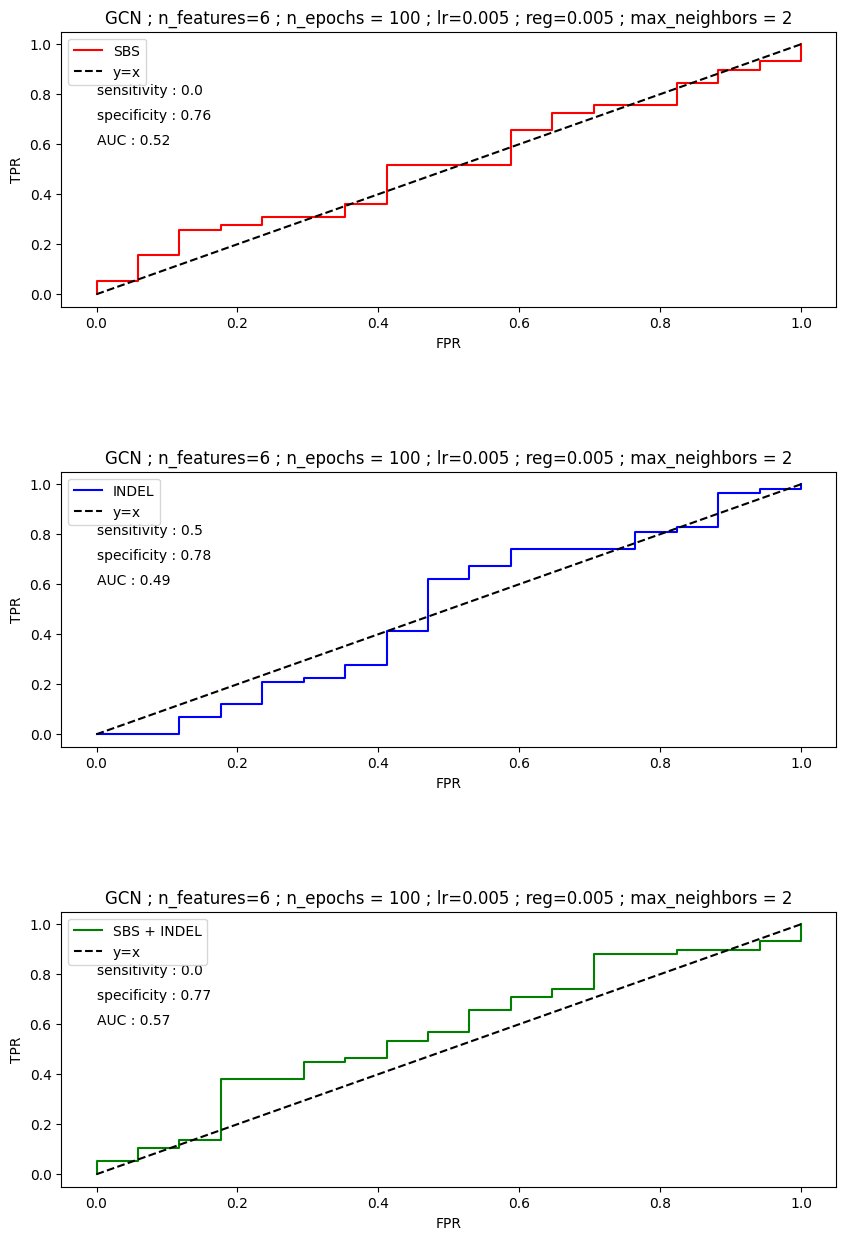

In [29]:
fig = plt.figure()
x = np.linspace(0,1,100)

# No sigmut
ax0 = fig.add_subplot(311)
ax0.plot(fpr_sbs, tpr_sbs, color='red',label='SBS')
ax0.plot(x,x,linestyle='--',color='black',label='y=x')
ax0.set_xlabel("FPR")
ax0.set_ylabel("TPR")
ax0.set_title(f"GCN ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg} ; max_neighbors = {max_neighbors}")
ax0.text(0,0.8,f"sensitivity : {sensitivity_sbs}")
ax0.text(0,0.7,f"specificity : {specificity_sbs}")
ax0.text(0,0.6,f"AUC : {auc_sbs}")
ax0.legend()

# Only sigmut
ax2 = fig.add_subplot(312)
ax2.plot(fpr_indel, tpr_indel, color='blue',label='INDEL')
ax2.plot(x,x,linestyle='--',color='black',label='y=x')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
ax2.set_title(f"GCN ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg} ; max_neighbors = {max_neighbors}")
ax2.text(0,0.8,f"sensitivity : {sensitivity_indel}")
ax2.text(0,0.7,f"specificity : {specificity_indel}")
ax2.text(0,0.6,f"AUC : {auc_indel}")
ax2.legend()

# Initial biomarkers + sigmut
ax4 = fig.add_subplot(313)
ax4.plot(fpr_comb, tpr_comb, color='green',label='SBS + INDEL')
ax4.plot(x,x,linestyle='--',color='black',label='y=x')
ax4.set_xlabel("FPR")
ax4.set_ylabel("TPR")
ax4.set_title(f"GCN ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg} ; max_neighbors = {max_neighbors}")
ax4.text(0,0.8,f"sensitivity : {sensitivity_comb}")
ax4.text(0,0.7,f"specificity : {specificity_comb}")
ax4.text(0,0.6,f"AUC : {auc_comb}")
ax4.legend()

plt.gcf().set_size_inches(10,15)
plt.subplots_adjust(hspace=0.6,wspace=0.6)
plt.show()

SBS :


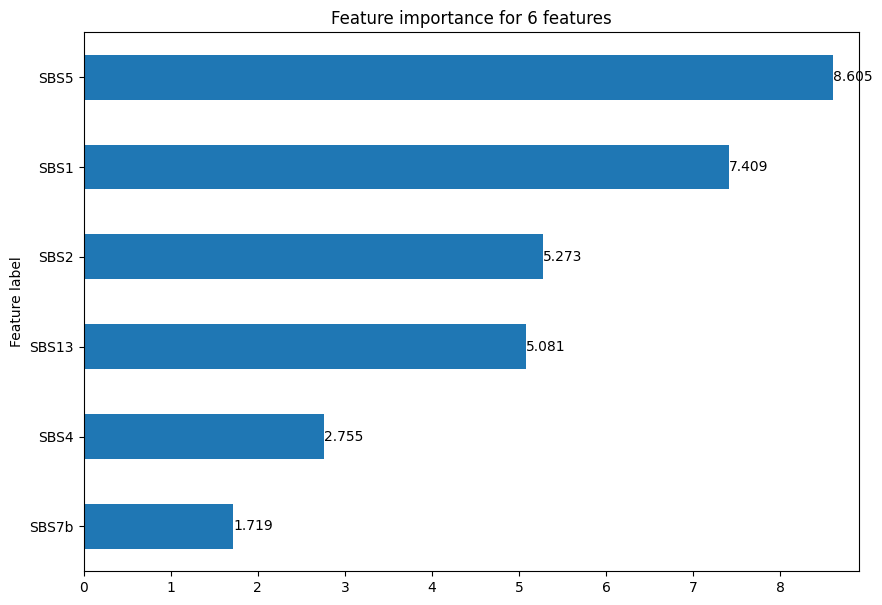

INDEL :


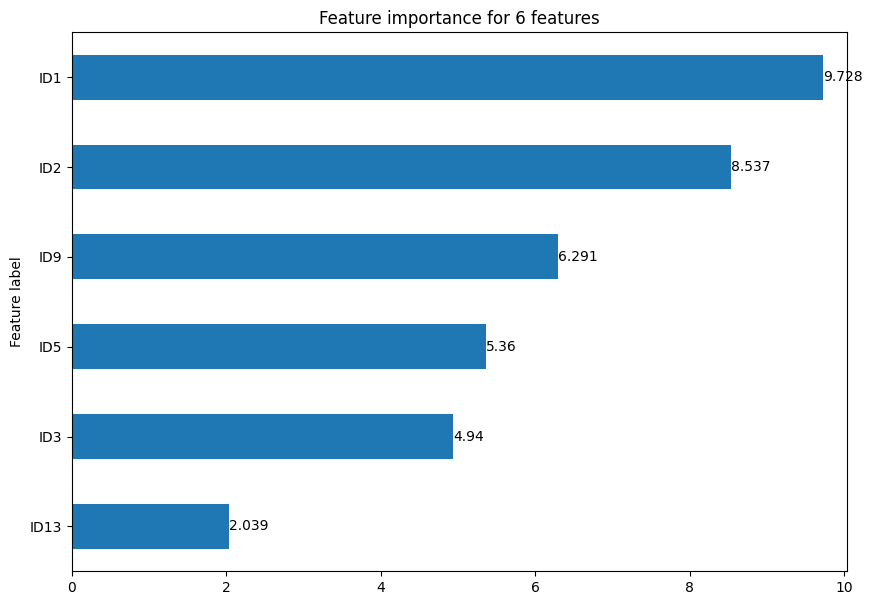

SBS + INDEL


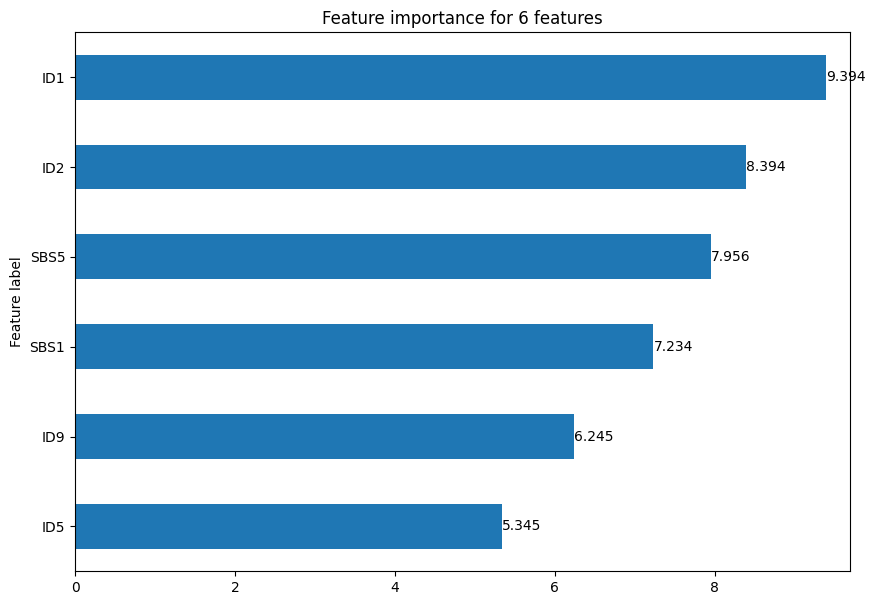

In [30]:
print("SBS :")
explanation_sbs.visualize_feature_importance(feat_labels=features_name_sbs)

print("INDEL :")
explanation_indel.visualize_feature_importance(feat_labels=features_name_indel)

print("SBS + INDEL")
explanation_comb.visualize_feature_importance(feat_labels=features_name_comb)

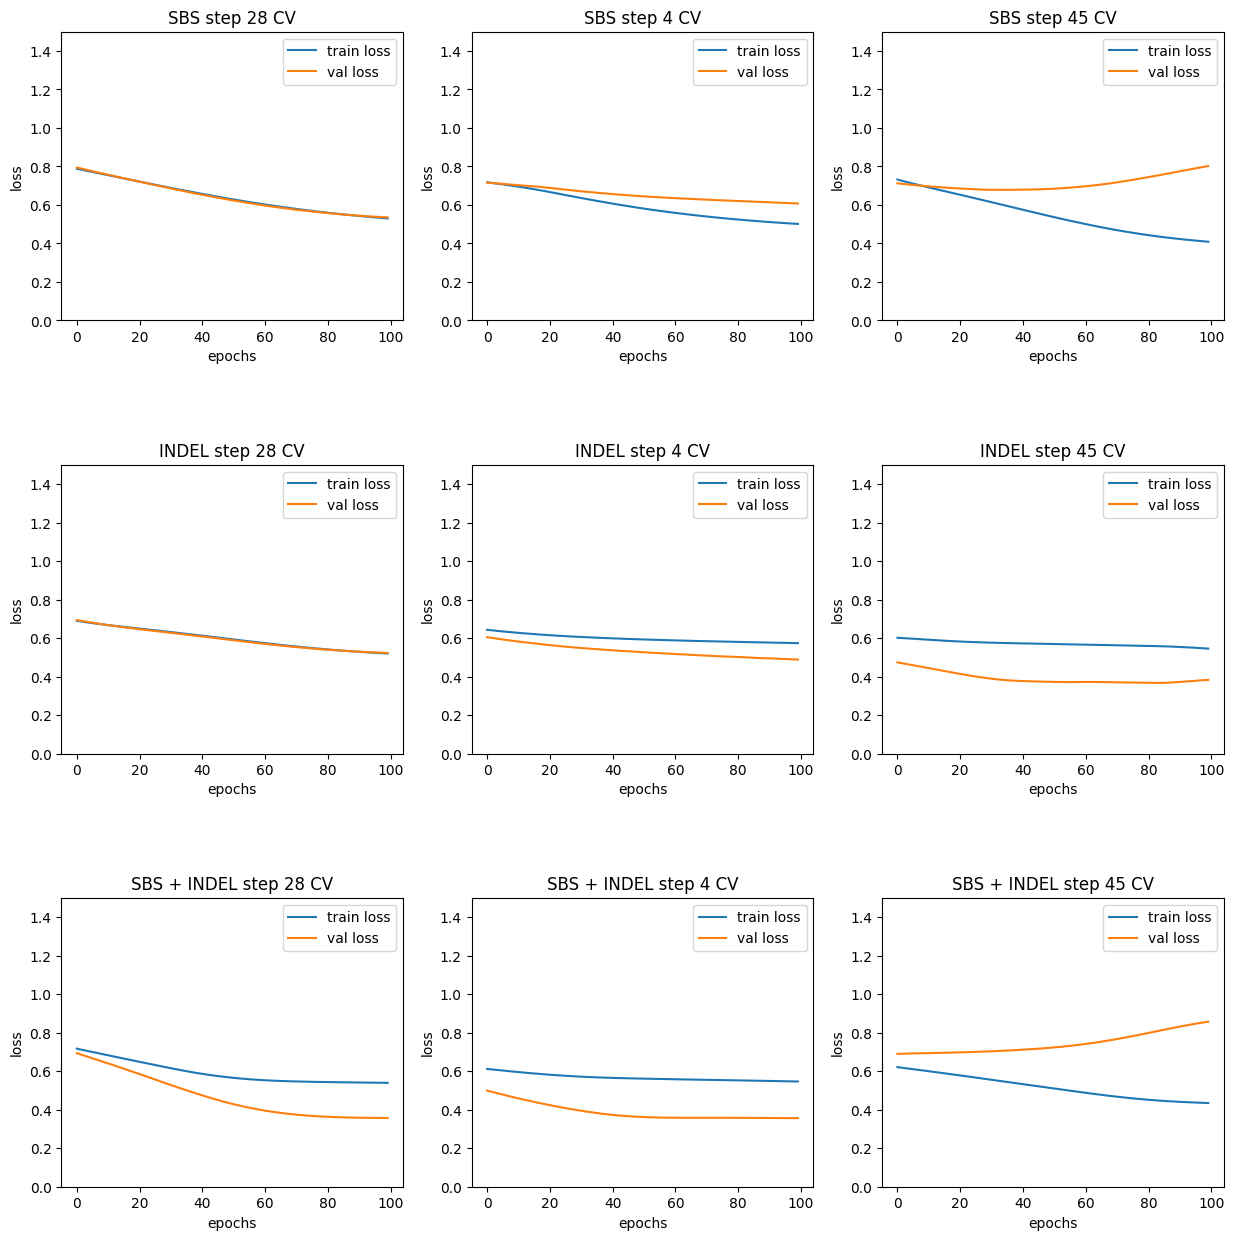

In [31]:
epochs = [k for k in range(n_epochs)]

fig, ax = plt.subplots(3,3,figsize=(15,15))

patient0 = np.random.randint(0,df.shape[0]-1)
patient1 = np.random.randint(0,df.shape[0]-1)
patient2 = np.random.randint(0,df.shape[0]-1)

# No sigmut :
ax[0,0].plot(epochs, train_loss_sbs[patient0],label='train loss')
ax[0,0].plot(epochs, val_loss_sbs[patient0],label='val loss')
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('loss')
ax[0,0].set_title(f'SBS step {patient0} CV')
ax[0,0].set_ylim(0,1.5)
ax[0,0].legend()

ax[0,1].plot(epochs, train_loss_sbs[patient1],label='train loss')
ax[0,1].plot(epochs, val_loss_sbs[patient1],label='val loss')
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('loss')
ax[0,1].set_title(f'SBS step {patient1} CV')
ax[0,1].set_ylim(0,1.5)
ax[0,1].legend()

ax[0,2].plot(epochs, train_loss_sbs[patient2],label='train loss')
ax[0,2].plot(epochs, val_loss_sbs[patient2],label='val loss')
ax[0,2].set_xlabel('epochs')
ax[0,2].set_ylabel('loss')
ax[0,2].set_title(f'SBS step {patient2} CV')
ax[0,2].set_ylim(0,1.5)
ax[0,2].legend()

# Only sigmut :
ax[1,0].plot(epochs, train_loss_indel[patient0],label='train loss')
ax[1,0].plot(epochs, val_loss_indel[patient0],label='val loss')
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('loss')
ax[1,0].set_title(f'INDEL step {patient0} CV')
ax[1,0].set_ylim(0,1.5)
ax[1,0].legend()

ax[1,1].plot(epochs, train_loss_indel[patient1],label='train loss')
ax[1,1].plot(epochs, val_loss_indel[patient1],label='val loss')
ax[1,1].set_xlabel('epochs')
ax[1,1].set_ylabel('loss')
ax[1,1].set_title(f'INDEL step {patient1} CV')
ax[1,1].set_ylim(0,1.5)
ax[1,1].legend()

ax[1,2].plot(epochs, train_loss_indel[patient2],label='train loss')
ax[1,2].plot(epochs, val_loss_indel[patient2],label='val loss')
ax[1,2].set_xlabel('epochs')
ax[1,2].set_ylabel('loss')
ax[1,2].set_title(f'INDEL step {patient2} CV')
ax[1,2].set_ylim(0,1.5)
ax[1,2].legend()

# Sigmut + other biomarkers :
ax[2,0].plot(epochs, train_loss_comb[patient0],label='train loss')
ax[2,0].plot(epochs, val_loss_comb[patient0],label='val loss')
ax[2,0].set_xlabel('epochs')
ax[2,0].set_ylabel('loss')
ax[2,0].set_title(f'SBS + INDEL step {patient0} CV')
ax[2,0].set_ylim(0,1.5)
ax[2,0].legend()

ax[2,1].plot(epochs, train_loss_comb[patient1],label='train loss')
ax[2,1].plot(epochs, val_loss_comb[patient1],label='val loss')
ax[2,1].set_xlabel('epochs')
ax[2,1].set_ylabel('loss')
ax[2,1].set_title(f'SBS + INDEL step {patient1} CV')
ax[2,1].set_ylim(0,1.5)
ax[2,1].legend()

ax[2,2].plot(epochs, train_loss_comb[patient2],label='train loss')
ax[2,2].plot(epochs, val_loss_comb[patient2],label='val loss')
ax[2,2].set_xlabel('epochs')
ax[2,2].set_ylabel('loss')
ax[2,2].set_title(f'SBS + INDEL step {patient2} CV')
ax[2,2].set_ylim(0,1.5)
ax[2,2].legend()
plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.0, 'SBS graph used in GCN, max_neighbors=2')

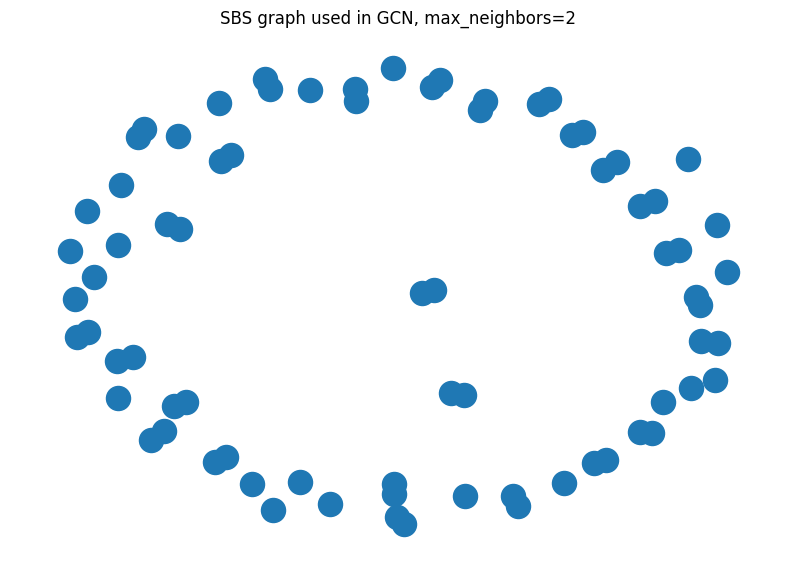

In [32]:
nx_graph_sbs_print = nx_graph_sbs.copy()
for node in list(nx_graph_sbs_print.nodes):
    nx_graph_sbs_print.remove_edge(node,node)

fig, ax = plt.subplots(figsize=(10,7))
nx.draw(nx_graph_sbs_print)
plt.title(f"SBS graph used in GCN, max_neighbors={max_neighbors}")

Text(0.5, 1.0, 'INDEL graph used in GCN, max_neighbors=2')

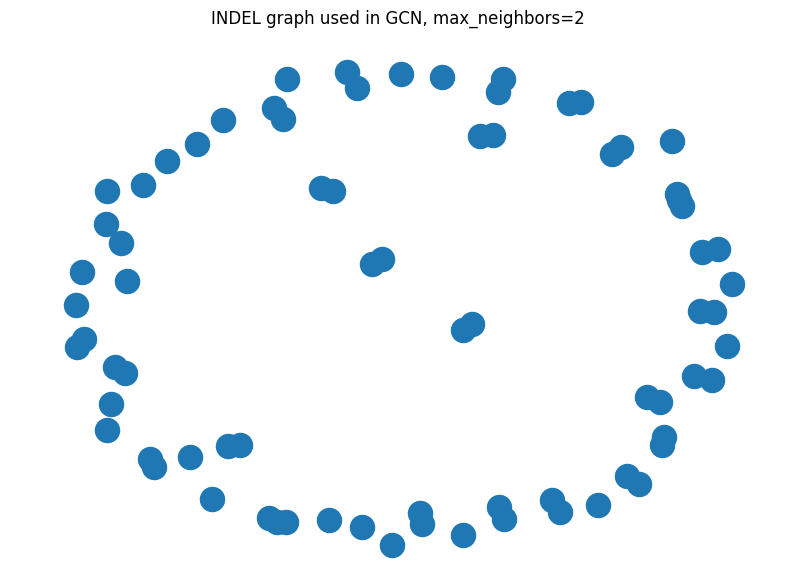

In [33]:
nx_graph_indel_print = nx_graph_indel.copy()
for node in list(nx_graph_indel_print.nodes):
    nx_graph_indel_print.remove_edge(node,node)

fig, ax = plt.subplots(figsize=(10,7))
nx.draw(nx_graph_indel_print)
plt.title(f"INDEL graph used in GCN, max_neighbors={max_neighbors}")

Text(0.5, 1.0, 'SBS + INDEL graph used in GCN, max_neighbors=2')

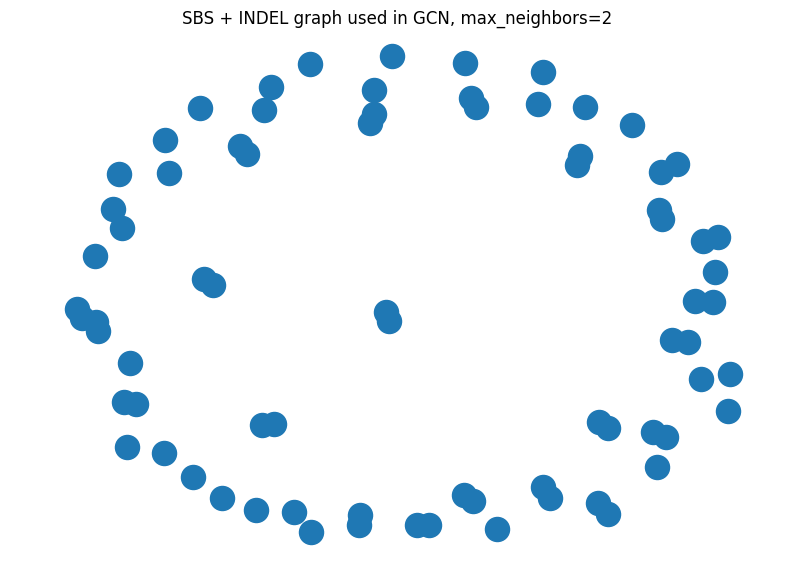

In [34]:
nx_graph_comb_print = nx_graph_comb.copy()
for node in list(nx_graph_comb_print.nodes):
    nx_graph_comb_print.remove_edge(node,node)

fig, ax = plt.subplots(figsize=(10,7))
nx.draw(nx_graph_comb_print)
plt.title(f"SBS + INDEL graph used in GCN, max_neighbors={max_neighbors}")